In [1]:
import os

# Set the proxy environment variables
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [2]:
import ee
import datetime
import itertools
import sys
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [3]:
ee.Initialize()

In [4]:
sample_path = 'users/wangjinzhulala/China_built_up/04_sample_train_test_split'

In [16]:
# define basic parameters
year_span = [f'{i}_{i+2}' for i in range(2020,2023,3)]

In [8]:
region_cn = '华北'
region_en = 'huabei'

### Step_1: Prepare input classification_img, control_sample, and sample_size

In [19]:
# import the untouched control points, which are diveded by a random column with a 101 random state
Sample  = [ee.FeatureCollection(f'{sample_path}/Training_sample_{region_en}_{year}') for year in year_span]

In [20]:
# prepare the different input band types
in_band_selection =[#'Spectrum',
                    #'Spectrum_Normalize',
                    #'Spectrum_Normalize_Fourier',
                    #'Spectrum_Normalize_Fourier_Terrain',
                    'Spectrum_Normalize_Fourier_Terrain_Meterology']

In [26]:
# import the classified imgs
img_path = 'users/wangjinzhulala/China_built_up/05_primary_classification'

Classified_Landsat_1990_2019 = {}

# get the sum of 10-folds-classification
for in_band in in_band_selection:
    for i,year in enumerate(year_span):
        
        img_name = f'{in_band}_{region_en}_{year}'    
        preliminary_classification = ee.ImageCollection([ee.Image(f'{img_path}/{img_name}_{seed}_patch') for seed in range(10)]).sum()
        test_sample = Sample[i]
        
        Classified_Landsat_1990_2019.update({f'{year}':( preliminary_classification,
                                                         test_sample,
                                                         test_sample.size().getInfo())} ) 

In [27]:
Input_df = pd.DataFrame(Classified_Landsat_1990_2019).T
Input_df.columns = ['classification_img','sample_pt','sample_size']
Input_df

,classification_img,sample_pt,sample_size
2020_2022,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.FeatureCollection({\n ""functionInvocationV...",2792


### Step_2: Loop through each threshold and extract classification value to samples for later comparsion

In [28]:
Threshold_acc = {}

for idx,row in Input_df.iterrows():
    
    img = row[0]
    sample = row[1]
    sample_size = row[2]
    
    for threshold in range(10):
    
        # apply the threshold to the sum of 10 classifications,rename so we can use Accuracyassement module
        img_threshold = img.gt(threshold).rename('classification')

        # extract reclassified GAIA pixel value to test_sample
        sample_with_value = img_threshold.sampleRegions(collection = sample, 
                                                        properties = ['Built'], 
                                                        scale      = 30)

        # Put the result into a dict
        Threshold_acc[(idx,threshold)] = [sample_with_value,sample_size]

In [29]:
# formating the dataframe
Threshold_acc_df = pd.DataFrame(Threshold_acc).T
Threshold_acc_df.reset_index(inplace=True)
Threshold_acc_df.columns = ['Year','Threshold','Feature','Sample_size']

### Step_3: Calculate the number of correct classified points, then get the accuracy

In [30]:
correct_num_list = []

for idx,row in Threshold_acc_df.iterrows():
    
    # If the 'Built' and 'classification' attribute are same, then it will be a correct classified point
    correct_num = row[2].filter(ee.Filter.equals('Built',None,'classification')).size().getInfo()
    correct_num_list.append(correct_num)
    
    print(f'Compute the correct classified points number of {row[0]}_{row[1]} finished')

Compute the correct classified points number of 2020_2022_0 finished
Compute the correct classified points number of 2020_2022_1 finished
Compute the correct classified points number of 2020_2022_2 finished
Compute the correct classified points number of 2020_2022_3 finished
Compute the correct classified points number of 2020_2022_4 finished
Compute the correct classified points number of 2020_2022_5 finished
Compute the correct classified points number of 2020_2022_6 finished
Compute the correct classified points number of 2020_2022_7 finished
Compute the correct classified points number of 2020_2022_8 finished
Compute the correct classified points number of 2020_2022_9 finished


In [36]:
# formating the dataframe
Threshold_acc_df['Correct_num'] = correct_num_list
Threshold_acc_df['Accuracy'] = Threshold_acc_df['Correct_num'] /Threshold_acc_df['Sample_size'] *100
Threshold_acc_df['Year'] = Threshold_acc_df['Year'].astype('category')

# make the threshold categorical so we can make figures
Threshold_acc_df['Threshold'] = Threshold_acc_df['Threshold'].astype('category')
Threshold_acc_df['Year'] = Threshold_acc_df['Year'].astype('category')

##### Observe that the best threshold is 4

<Axes: xlabel='Threshold', ylabel='Accuracy'>

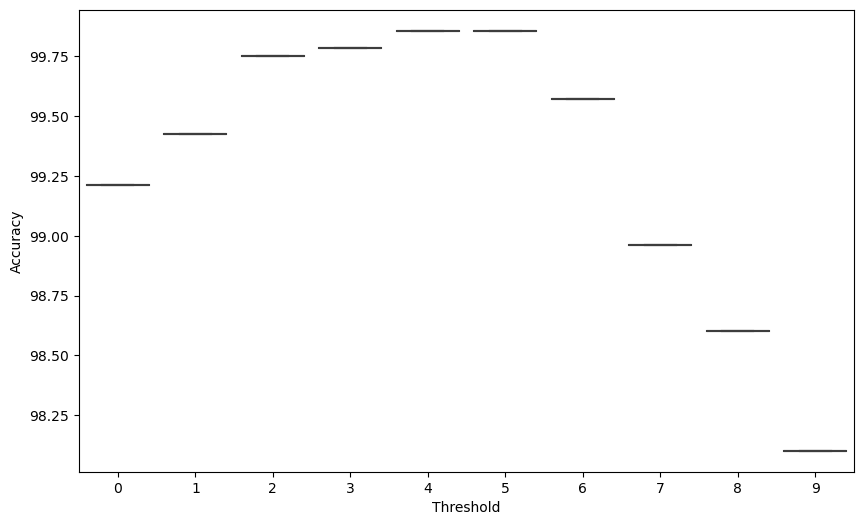

In [38]:
plt.figure(figsize=(10,6))
sns.boxplot(data=Threshold_acc_df,
            x='Threshold',
            y='Accuracy')

##### Compare with original accuracy

In [41]:
# import the original accuracy for comparison
Original_acc = pd.read_csv(f'../Sub_Process_7_Before_classification_Sensitivity_test/Result/Grid_acc_tree.csv')
Original_acc = Original_acc[(Original_acc['In_Bands']=='Spectrum_Normalize_Fourier_Terrain_Meterology')&
                            (Original_acc['Tree']==100)]
Original_acc = Original_acc[['Year','Accuracy']]
Original_acc['Accuracy'] =Original_acc['Accuracy'] * 100
Original_acc['Region'] = region_en
Original_acc['Type'] = 'Original'

In [ ]:
Threshold_acc_df_4 = Threshold_acc_df[Threshold_acc_df['Threshold']==4]
Threshold_acc_df_4 = Threshold_acc_df_4[['Year','Accuracy']]
Threshold_acc_df_4['Region'] = region_en
Threshold_acc_df_4['Type'] = 'Ten_folds_check'

In [ ]:
sns.lineplot(x='Year',y='Accuracy',data=Threshold_acc_df_4)
sns.lineplot(x='Year',y='Accuracy',data=Original_acc)